load libraries

In [1]:
import cv2
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


# 加载数据集

猫狗大战：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
from tqdm import tqdm

np.random.seed(2017)

model_image_size = 299

n = 25000
X = np.zeros((n, model_image_size, model_image_size, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    image = cv2.imread( "data0/train/cats/cat.%d.jpg" % i)
    X[i] = cv2.resize(image, (model_image_size, model_image_size))
    image = cv2.imread('data0/train/dogs/dog.%d.jpg' % i)
    X[i+n//2] = cv2.resize(image, (model_image_size, model_image_size))

y[n//2:] = 1

100%|██████████| 12500/12500 [01:00<00:00, 208.29it/s]


# 分为训练集和验证集

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(len(X_train))
print(len(X_valid))

20000
5000


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py


In [4]:
base_model = InceptionV3(input_tensor=Input((model_image_size, model_image_size, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

print("done")

done


In [5]:
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
print("done")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

# 训练模型

In [16]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

model.save("models/inceptionV3-mymodel.h5")

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 152s - loss: 0.2202 - acc: 0.9260 - val_loss: 0.1116 - val_acc: 0.9720

# 可视化模型

https://keras.io/visualization/

/home/jidou/anaconda3/lib/python3.6/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


load successed


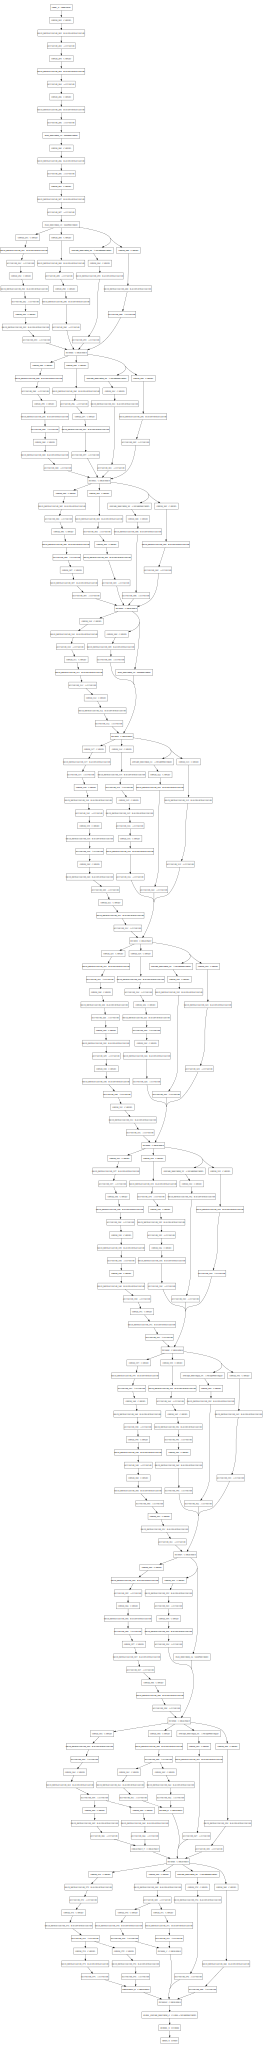

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/inceptionV3-mymodel.h5")
print("load successed")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [8]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_4 - 0
conv2d_283 - 1
batch_normalization_283 - 2
activation_283 - 3
conv2d_284 - 4
batch_normalization_284 - 5
activation_284 - 6
conv2d_285 - 7
batch_normalization_285 - 8
activation_285 - 9
max_pooling2d_13 - 10
conv2d_286 - 11
batch_normalization_286 - 12
activation_286 - 13
conv2d_287 - 14
batch_normalization_287 - 15
activation_287 - 16
max_pooling2d_14 - 17
conv2d_291 - 18
batch_normalization_291 - 19
activation_291 - 20
conv2d_289 - 21
conv2d_292 - 22
batch_normalization_289 - 23
batch_normalization_292 - 24
activation_289 - 25
activation_292 - 26
average_pooling2d_28 - 27
conv2d_288 - 28
conv2d_290 - 29
conv2d_293 - 30
conv2d_294 - 31
batch_normalization_288 - 32
batch_normalization_290 - 33
batch_normalization_293 - 34
batch_normalization_294 - 35
activation_288 - 36
activation_290 - 37
activation_293 - 38
activation_294 - 39
mixed0 - 40
conv2d_298 - 41
batch_normalization_298 - 42
activation_298 - 43
conv2d_296 - 44
conv2d_299 - 45
batch_normalization_296 - 46
batch_nor

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [18]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    plt.figure(figsize=(12, 14))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = cv2.imread('data0/test/test1/%d.jpg' % (100*i + 31))
        img = cv2.resize(img, (299, 299))
        x = img.copy()
        x.astype(np.float32)
        out, prediction = model_show.predict(np.expand_dims(x, axis=0))

        prediction = prediction[0]
        out = out[0]

        if prediction < 0.5:
            plt.title('cat %.2f%%' % (100 - prediction*100))
        else:
            plt.title('dog %.2f%%' % (prediction*100))

        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (299, 299))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


layer_output Tensor("mixed10_2/concat:0", shape=(?, 8, 8, 2048), dtype=float32)
weights shape (2048, 1)


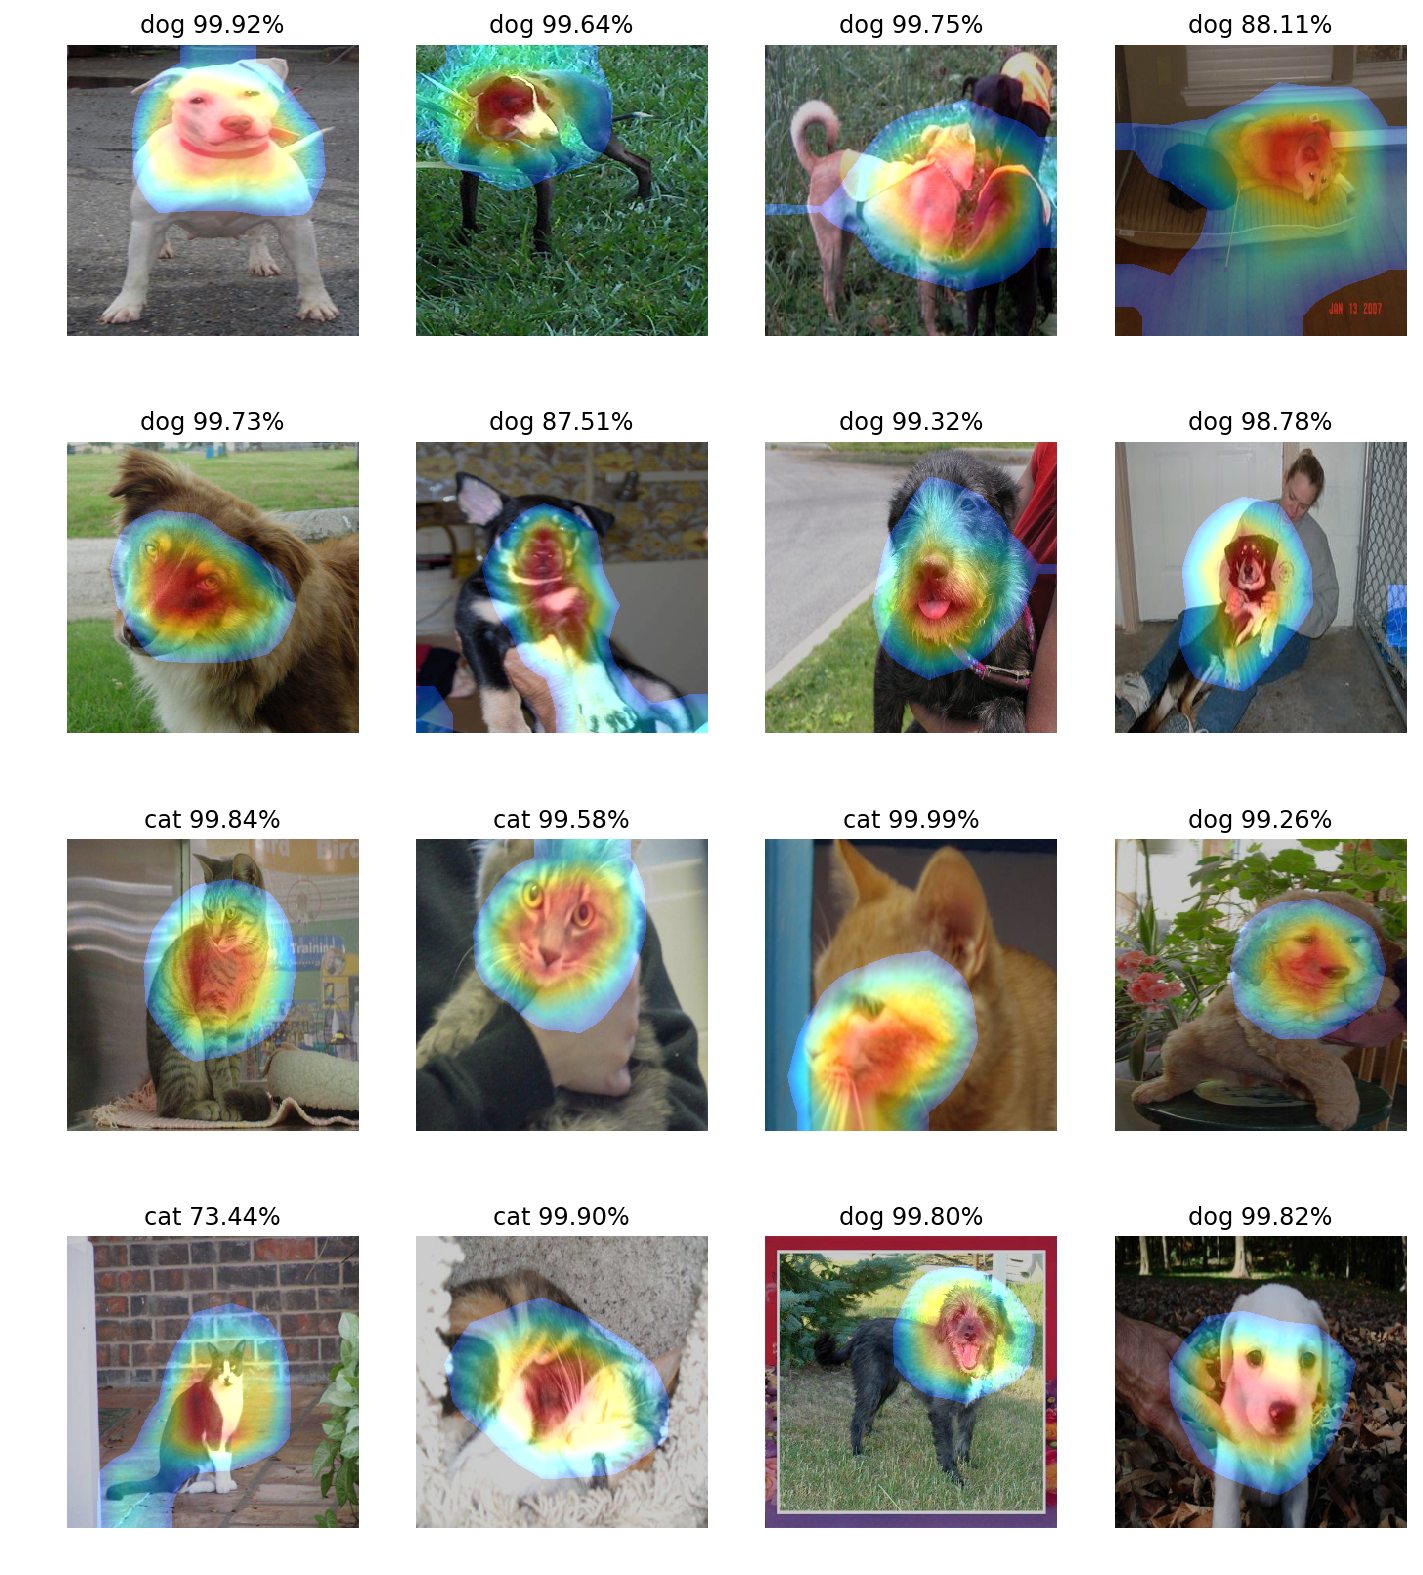

In [24]:
weights = model.layers[313].get_weights()[0]
layer_output = model.layers[310].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)